<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/df_imputed_week_shift_start_2017_added_holiday_weekends", index_col = 0, parse_dates = True)

In [0]:
cols = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit", "holiday", "weekend"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "10T", method_speed = np.mean, method_flow = np.sum):
    copied = df.copy()
    copied = copied.resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow,
           "speed_limit": np.median, "holiday": np.median, "weekend": np.median})
    return copied

In [0]:
r_df = resample_df(df, freq = "15T")

In [0]:
# Change speed_limit to binary
r_df['speed_limit'] =  np.where(r_df.speed_limit > 110, 1, 0)

df['weekend'] = np.where(df.index.weekday > 4, 1, 0)

### Train test split. The final year is reserved for testing. (Val will be relevant later?)

In [0]:
def train_val_test_split(df, val_year, test_year):
    # train, test
    return df[(df.index.year < val_year)].copy(), df[df.index.year == val_year].copy(), df[df.index.year == test_year].copy()

In [0]:
train, val, test = train_val_test_split(r_df, 2018, 2019)

In [0]:
import numpy as np
def log_transform(df):
    copy = df.copy()
    return np.log(copy.iloc[:, :-3].replace(0, 1e-15)).join(df.iloc[:, -3:], how = 'inner')

# Log transform. First set 0s to very low value 'cause you can't log 0.
train_log = log_transform(train)
val_log = log_transform(val)
test_log = log_transform(test)

In [29]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.1.0-rc1'

In [0]:
# ML
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [0]:
X_train = np.array(train_log)
y_train = np.array(train_log.speed)

X_val = np.array(val_log)
y_val = np.array(val_log.speed)

X_test = np.array(test_log)
y_test = np.array(test_log.speed)

In [0]:
lookback = int(4 * (60 / 15))

train_gen = TimeseriesGenerator(data = X_train, targets = y_train, length = lookback)
val_gen = TimeseriesGenerator(data = X_val, targets = y_val, length = lookback)
test_gen = TimeseriesGenerator(data = X_test, targets = y_test, length = lookback)

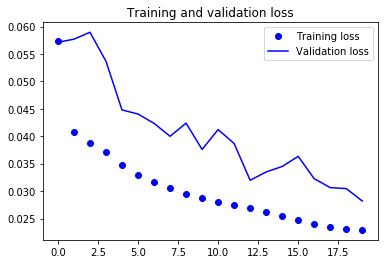

In [0]:
import matplotlib.pyplot as plt

#PLOT
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

  ...
    to  
  ['...']
Train for 274 steps, validate for 274 steps
Epoch 1/20
274/274 [==============================] - 13s 49ms/step - loss: 1.6763 - val_loss: 0.0222
Epoch 2/20
274/274 [==============================] - 11s 40ms/step - loss: 0.0210 - val_loss: 0.0191
Epoch 3/20
274/274 [==============================] - 11s 40ms/step - loss: 0.0172 - val_loss: 0.0160
Epoch 4/20
274/274 [==============================] - 11s 40ms/step - loss: 0.0153 - val_loss: 0.0138
Epoch 5/20
274/274 [==============================] - 11s 40ms/step - loss: 0.0142 - val_loss: 0.0123
Epoch 6/20
274/274 [==============================] - 11s 40ms/step - loss: 0.0131 - val_loss: 0.0107
Epoch 7/20
274/274 [==============================] - 11s 40ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 8/20
274/274 [==============================] - 11s 39ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 9/20
274/274 [==============================] - 11s 40ms/step - loss: 0.0103 - val_loss: 0.0085
Epoch 10/20
2

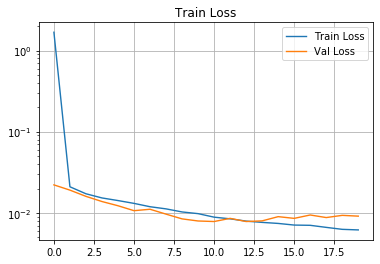

In [63]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import pdb
import matplotlib.pyplot as plt

############## Define Neural Network Class ##############
class neural_net(tf.keras.Model):
    def __init__(self, lookback = 24, regularization = 1e-6): #You can choose to have more input here! E.g. number of neurons.
        super(neural_net, self).__init__()

        #Define l2 regularization.
        self.regularization = regularization
        regu = tf.keras.regularizers.l2(self.regularization)

        self.lookback = lookback

        #Define Layers
        self.conv1 = tf.keras.layers.Conv1D(filters = 32, kernel_size = (1), use_bias = True, kernel_regularizer = regu)
        self.prelu1 = tf.keras.layers.PReLU()
        self.lstm1 = tf.keras.layers.LSTM(32, dropout = 0.1, recurrent_dropout = 0.5, input_shape = (self.lookback, 32), kernel_regularizer = regu)
        self.prelu2 = tf.keras.layers.PReLU()
        self.dense1 = tf.keras.layers.Dense(1, activation = 'linear', use_bias = True, kernel_regularizer = regu)

    #Define the forward propagation
    def call(self, inputs):

        x = self.conv1(inputs)
        x = self.prelu1(x)
        x = self.lstm1(x)
        x = self.prelu2(x)
        x = self.dense1(x)

        return x

#Create an instance of you neural network model
model = neural_net(lookback = 24 * 4, regularization = 1e-6)

#Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

#Define loss function
mse_loss_fn = tf.keras.losses.MeanSquaredError()

#Compile model
model.compile(optimizer = optimizer, loss = mse_loss_fn)

#Train model
history = model.fit(train_gen, validation_data = val_gen, epochs = 20)
train_loss, val_loss = history.history['loss'], history.history['val_loss']

#Evaluate on test set
test_loss = model.evaluate(test_gen)
print('Test Loss: ' + str(test_loss))


#Plot test and validation loss
plt.figure()
plt.semilogy(train_loss,linewidth = 1.4)
plt.semilogy(val_loss,linewidth = 1.4)
plt.legend(['Train Loss', 'Val Loss'])
plt.grid(True)
plt.title('Train Loss')
plt.show()


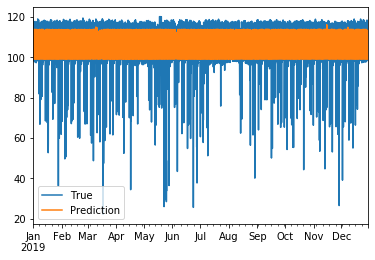

In [0]:
#PLOT
preds.plot()

In [0]:
preds.describe()

,True,Prediction
count,8712.000000,8702.000000
mean,102.937465,104.151741
std,10.748936,5.751995
min,22.254722,98.989693
25%,97.910625,99.393486
50%,99.273889,100.403145
75%,113.051944,110.907471
max,120.000000,115.989548


In [0]:
## Min-max scaling (old stuff)
def calc_mean(df, col):
    # mean(100), mean(120)
    return df.groupby(['speed_limit'])[col].mean().values

def calc_sd(df, col):
    # sd(100), sd(120)
    return df.groupby(['speed_limit'])[col].std().values

def normalize_df(df, cols):
    copy = df.copy()
    for col in cols:
        # Find mean and sd for column
        mean100, mean120 = calc_mean(copy, col)
        sd100, sd120 = calc_sd(copy, col)
        copy[col] = np.where(copy.speed_limit == 100, (copy[col] - mean100) / sd100, (copy[col] - mean120) / sd120)
    return copy


train_norm = normalize_df(train_log, cols[:-1])
val_norm = normalize_df(val_log, cols[:-1])

train2 = train.speed.values
train2 = train2.reshape(-1, 1)

val2 = val.speed.values
val2 = val2.reshape(-1, 1)

test2 = test.speed.values
test2 = test2.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train2)

train.loc[:, 'speed'] = scaler.transform(train2)
val.loc[:, 'speed'] = scaler.transform(val2)

test_data = test.iloc[:, 0].values
test_data = np.reshape(test_data, (-1, 1))
test_data = scaler.transform(test2)